In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

import torch.optim as optim


# Data preprocessing utils : 
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# my defined model
from utils.acdc_dataset import *
from utils.funcs import *
from utils.vqvae import *

In [2]:
######################## Parameters ######################

# dataset params :
L = 128  # length of input images
data_modality = 'MRI'  # either 'SEG' to use segmentation dataset or 'MRI' for gray-scale MRIs
loss_func = 'smoothL1'

# training params
BATCH_SIZE = 32
lr = 5e-4
epochs = 100
model_name = 'saved_models/mri/512_64_4_smoothl1.pth'


# model hyper-params :
K =  512 # num_embeddings
D =  64  # embedding_dim 
downsampling_factor = 4

use_residual = False # swicth to True if wants to use RQ-VAE
num_quantizers = 0
shared_codebook = False

beta = .25
decay = .8

kmeans_init = True
kmeans_iters = 10



In [3]:


#################### dataset init ######################
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


train_dataset = load_dataset(train_set_path, modality= data_modality)
test_dataset  = load_dataset(test_set_path, modality= data_modality)


if data_modality == 'SEG':
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        One_hot_Transform(num_classes=4)
        ])
else : 
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        PercentileClip(lower_percentile=1, upper_percentile=99),
        MinMaxNormalize(min_value=0.0, max_value=1.0),
        ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = False)




In [4]:

# instanciate model :

VQ_VAE =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                residual = use_residual,
                num_quantizers = num_quantizers,
                shared_codebook = shared_codebook,
                beta = beta,
                decay = decay,
                data_mod = data_modality,
                kmeans_init = kmeans_init,
                kmeans_iters = kmeans_iters,
                loss_func = loss_func
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VQ_VAE.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


In [8]:

model.train()

train_loss_values    = []
commit_loss_values   = []
val_loss_values      = []


best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss  = []
    commit_loss = []

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commitement_Loss = model(inputs)
            
            # Loss and backward
            all_loss = model.loss_function(output, inputs, indices, commitement_Loss)
            loss = all_loss['loss']  # Use the loss function defined in the model
            recons_loss = all_loss['Reconstruction_Loss']
            commitement_Loss = all_loss['commitement_Loss']

            loss.backward()
            optimizer.step()
                        
            # Track running loss
            train_loss.append( recons_loss.item() )
            commit_loss.append( commitement_Loss.item() )

            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    train_loss_values.append( np.mean(train_loss))
    commit_loss_values.append( np.mean(commit_loss))

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, commit_loss_values, val_loss)
        best_val_loss = val_loss

    print('Epoch {}: '.format(epoch))


print("Training complete.")

100%|██████████| 60/60 [00:09<00:00,  6.66batch/s, loss=0.0841]


Epoch 0: 


100%|██████████| 60/60 [00:06<00:00,  8.62batch/s, loss=0.0845]


Epoch 1: 


100%|██████████| 60/60 [00:06<00:00,  8.61batch/s, loss=0.0765]


Epoch 2: 


100%|██████████| 60/60 [00:06<00:00,  8.66batch/s, loss=0.0841]


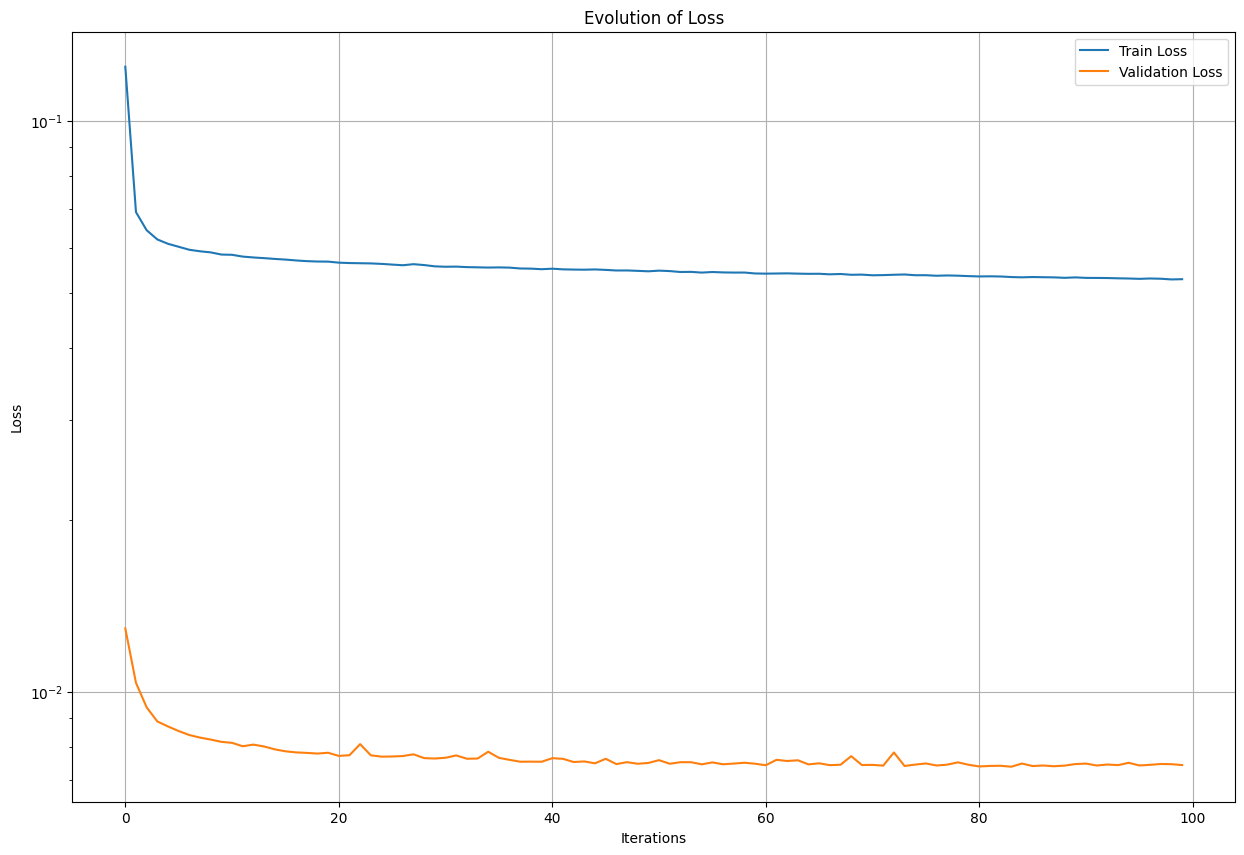

In [ ]:
plot_train_val_loss(train_loss_values, val_loss_values)

## Test model

In [ ]:
vis_batch = next(iter(TestLoader)).to(device)

batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

In [ ]:

batch_hat = reconstruct_logits(vis_batch, model)
probs = F.softmax(batch_hat, dim=1) 

pred_seg = torch.argmax(probs,     dim=1).detach().cpu()
true_seg = torch.argmax(vis_batch, dim=1).detach().cpu()

visualize_errors(true_seg, pred_seg, 'Prediction errors visualization')

## Evaluate model score : 

In [4]:
model_path = 'saved_models/dummy_model.pth'

model =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                residual = use_residual,
                num_quantizers = num_quantizers,
                shared_codebook = shared_codebook,
                beta = beta,
                decay = decay,
                data_mod = data_modality
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_2693572/2186757886.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [5]:
checkpoint = torch.load(model_path)

# Extract and print all parameters
print("Checkpoint Parameters:")
print("-" * 30)
print(f"Epoch: {checkpoint['epoch']}")
print(f"K (Codebook Size): {checkpoint['K']}")
print(f"D (Codebook Dimension): {checkpoint['D']}")
print(f"Train Loss Values: {checkpoint['train_loss_values']}")
print(f"Validation Loss Values: {checkpoint['val_loss_values']}")
print(f"Codebook Loss Values: {checkpoint['codebook_loss_values']}")
# print(f"Codebook: {checkpoint['codebook']}")


Checkpoint Parameters:
------------------------------
Epoch: 4
K (Codebook Size): 128
D (Codebook Dimension): 64
Train Loss Values: [0.14006701086958248, 0.0687773771584034, 0.05146617523084084, 0.04804149201760689, 0.043707962272067864]
Validation Loss Values: [0.5361904063645531, 0.43798475055133596, 0.39592140387086305, 0.38835453285890464, 0.3722327667124131]
Codebook Loss Values: [0.0005727839184051694, 0.0, 0.0, 0.0, 0.0]


/tmp/ipykernel_2693572/3513098570.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [9]:
print(score_model(model, TestLoader, device))

0.007447223494048505


### CodeBook usage :

In [10]:
hist = codebook_hist_testset(model, TestLoader, device)
hist = hist/np.sum(hist)

 ONLY 16 OF CODES WERE USED FROM 512, WHICH MAKE 3.125 % OF CODES FROM THE CODE-BOOK


In [ ]:
def plot_codebook_usage(model, hist):
    

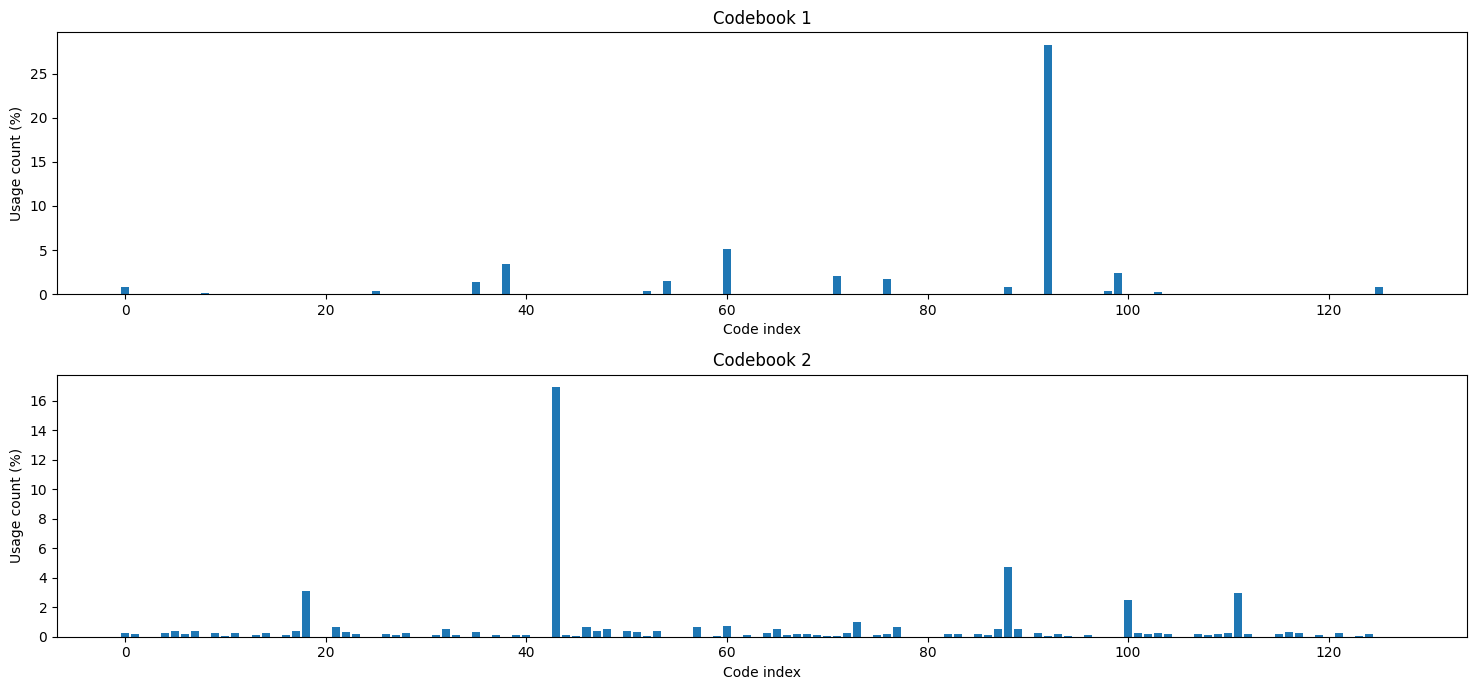

In [18]:
num_codebooks = len(model.vq_layer.codebook_sizes)
size_codebook = model.vq_layer.codebook_sizes[0]

fig, axs = plt.subplots(num_codebooks,1, figsize=(15, 7))

unused_codes_list = []
for i, hist_i in enumerate(hist):

    axs[i].bar(np.arange(size_codebook), hist_i*100)
    axs[i].set_title(f'Codebook {i+1}')
    axs[i].set_xlabel('Code index')
    axs[i].set_ylabel('Usage count (%)')

plt.tight_layout()
plt.show()

In [ ]:

_